# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

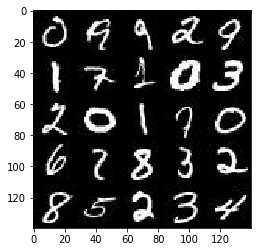

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

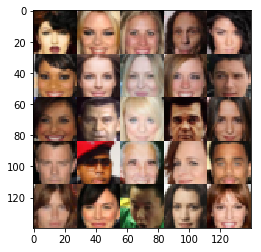

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_dim')
    learning_rate = tf.placeholder(tf.float32, name='lr')

    return input_image, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28*28*1 or 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # 14*14*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7*7*128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4*4*256
        
        # flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7*7*256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14*14*128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28*28*64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function   
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr =  model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                # random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images, input_z:batch_z})
                
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        
        print("final Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/5... Discriminator Loss: 0.7227... Generator Loss: 1.3470...
Epoch 1/5... Discriminator Loss: 0.8389... Generator Loss: 1.9021...
Epoch 1/5... Discriminator Loss: 1.1807... Generator Loss: 0.6064...
Epoch 1/5... Discriminator Loss: 1.1411... Generator Loss: 0.5948...
Epoch 1/5... Discriminator Loss: 0.9699... Generator Loss: 1.5181...


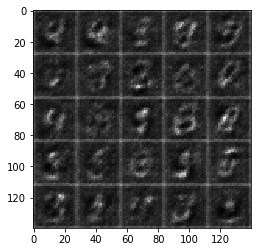

Epoch 1/5... Discriminator Loss: 0.9358... Generator Loss: 1.2820...
Epoch 1/5... Discriminator Loss: 0.8419... Generator Loss: 1.4418...
Epoch 1/5... Discriminator Loss: 0.8165... Generator Loss: 0.9514...
Epoch 1/5... Discriminator Loss: 0.8255... Generator Loss: 1.2789...
Epoch 1/5... Discriminator Loss: 0.7929... Generator Loss: 1.5666...


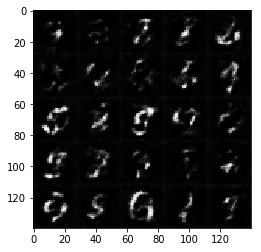

Epoch 1/5... Discriminator Loss: 0.7366... Generator Loss: 1.0308...
Epoch 1/5... Discriminator Loss: 0.7246... Generator Loss: 1.9749...
Epoch 1/5... Discriminator Loss: 0.7259... Generator Loss: 2.1374...
Epoch 1/5... Discriminator Loss: 0.5870... Generator Loss: 1.2656...
Epoch 1/5... Discriminator Loss: 0.6829... Generator Loss: 0.9594...


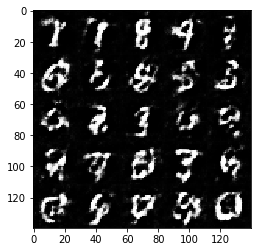

Epoch 1/5... Discriminator Loss: 0.5850... Generator Loss: 2.4374...
Epoch 1/5... Discriminator Loss: 0.6070... Generator Loss: 1.0893...
Epoch 1/5... Discriminator Loss: 0.6156... Generator Loss: 2.5001...
Epoch 1/5... Discriminator Loss: 0.6430... Generator Loss: 0.9914...
Epoch 1/5... Discriminator Loss: 0.4787... Generator Loss: 1.4422...


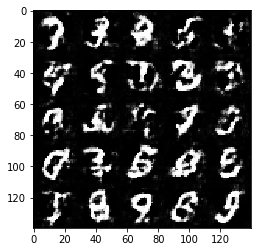

Epoch 1/5... Discriminator Loss: 0.5735... Generator Loss: 1.4655...
Epoch 1/5... Discriminator Loss: 0.4928... Generator Loss: 1.8471...
Epoch 1/5... Discriminator Loss: 0.5825... Generator Loss: 1.9284...
Epoch 2/5... Discriminator Loss: 0.6812... Generator Loss: 0.9616...
Epoch 2/5... Discriminator Loss: 0.7060... Generator Loss: 2.3512...


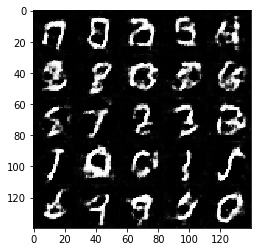

Epoch 2/5... Discriminator Loss: 0.7111... Generator Loss: 1.9685...
Epoch 2/5... Discriminator Loss: 1.0118... Generator Loss: 2.4590...
Epoch 2/5... Discriminator Loss: 0.6957... Generator Loss: 1.2762...
Epoch 2/5... Discriminator Loss: 0.7356... Generator Loss: 0.9324...
Epoch 2/5... Discriminator Loss: 0.9181... Generator Loss: 2.6082...


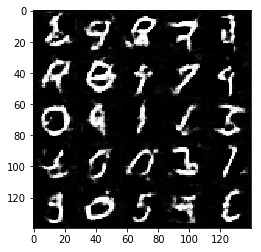

Epoch 2/5... Discriminator Loss: 0.9279... Generator Loss: 0.7094...
Epoch 2/5... Discriminator Loss: 0.7674... Generator Loss: 0.9204...
Epoch 2/5... Discriminator Loss: 0.7489... Generator Loss: 1.5343...
Epoch 2/5... Discriminator Loss: 0.7018... Generator Loss: 1.2717...
Epoch 2/5... Discriminator Loss: 0.7890... Generator Loss: 1.6547...


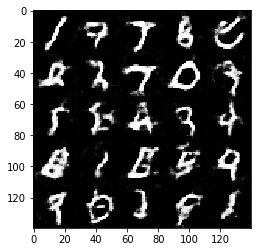

Epoch 2/5... Discriminator Loss: 0.7183... Generator Loss: 1.4827...
Epoch 2/5... Discriminator Loss: 0.7430... Generator Loss: 1.2462...
Epoch 2/5... Discriminator Loss: 0.7681... Generator Loss: 1.2019...
Epoch 2/5... Discriminator Loss: 0.7458... Generator Loss: 1.2964...
Epoch 2/5... Discriminator Loss: 0.7781... Generator Loss: 0.9817...


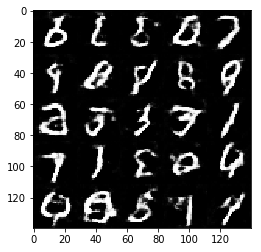

Epoch 2/5... Discriminator Loss: 0.8769... Generator Loss: 1.8853...
Epoch 2/5... Discriminator Loss: 0.8341... Generator Loss: 0.7897...
Epoch 2/5... Discriminator Loss: 0.7505... Generator Loss: 0.9687...
Epoch 2/5... Discriminator Loss: 0.6870... Generator Loss: 1.1260...
Epoch 2/5... Discriminator Loss: 0.6241... Generator Loss: 1.5302...


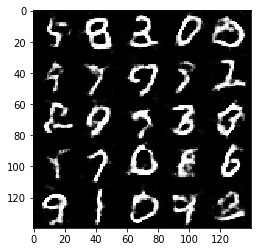

Epoch 2/5... Discriminator Loss: 0.7584... Generator Loss: 1.0049...
Epoch 3/5... Discriminator Loss: 0.6132... Generator Loss: 1.2384...
Epoch 3/5... Discriminator Loss: 0.6336... Generator Loss: 1.8739...
Epoch 3/5... Discriminator Loss: 0.8690... Generator Loss: 0.7346...
Epoch 3/5... Discriminator Loss: 0.8440... Generator Loss: 0.7346...


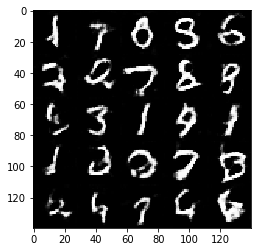

Epoch 3/5... Discriminator Loss: 0.9511... Generator Loss: 2.6807...
Epoch 3/5... Discriminator Loss: 0.5992... Generator Loss: 1.6057...
Epoch 3/5... Discriminator Loss: 0.7814... Generator Loss: 0.8314...
Epoch 3/5... Discriminator Loss: 0.7908... Generator Loss: 0.7988...
Epoch 3/5... Discriminator Loss: 0.5225... Generator Loss: 1.5327...


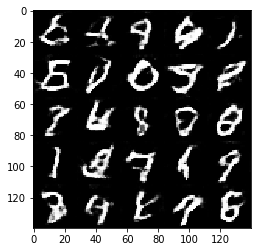

Epoch 3/5... Discriminator Loss: 0.6406... Generator Loss: 1.0437...
Epoch 3/5... Discriminator Loss: 0.6499... Generator Loss: 1.0452...
Epoch 3/5... Discriminator Loss: 0.6534... Generator Loss: 1.0348...
Epoch 3/5... Discriminator Loss: 1.1131... Generator Loss: 2.1959...
Epoch 3/5... Discriminator Loss: 0.6539... Generator Loss: 1.1045...


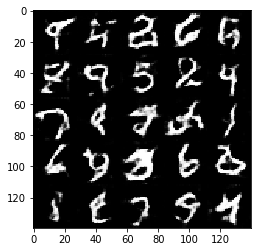

Epoch 3/5... Discriminator Loss: 0.5419... Generator Loss: 1.5939...
Epoch 3/5... Discriminator Loss: 0.5079... Generator Loss: 1.3634...
Epoch 3/5... Discriminator Loss: 0.6110... Generator Loss: 1.0646...
Epoch 3/5... Discriminator Loss: 0.9648... Generator Loss: 0.8494...
Epoch 3/5... Discriminator Loss: 0.5519... Generator Loss: 1.3380...


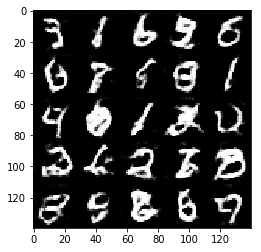

Epoch 3/5... Discriminator Loss: 0.4824... Generator Loss: 1.5238...
Epoch 3/5... Discriminator Loss: 0.5434... Generator Loss: 1.2854...
Epoch 3/5... Discriminator Loss: 0.5483... Generator Loss: 1.9399...
Epoch 3/5... Discriminator Loss: 0.7692... Generator Loss: 0.8538...
Epoch 3/5... Discriminator Loss: 0.4642... Generator Loss: 1.3658...


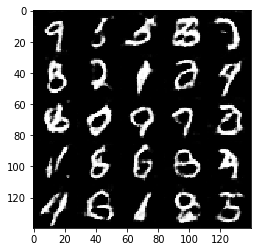

Epoch 4/5... Discriminator Loss: 0.5982... Generator Loss: 1.0390...
Epoch 4/5... Discriminator Loss: 3.2272... Generator Loss: 5.1032...
Epoch 4/5... Discriminator Loss: 0.6333... Generator Loss: 1.6537...
Epoch 4/5... Discriminator Loss: 1.0340... Generator Loss: 0.5831...
Epoch 4/5... Discriminator Loss: 0.6673... Generator Loss: 1.0502...


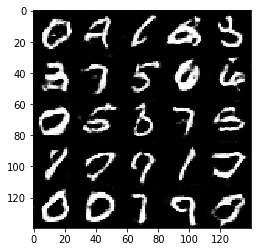

Epoch 4/5... Discriminator Loss: 0.6898... Generator Loss: 1.0561...
Epoch 4/5... Discriminator Loss: 0.5500... Generator Loss: 1.2168...
Epoch 4/5... Discriminator Loss: 0.7063... Generator Loss: 0.9737...
Epoch 4/5... Discriminator Loss: 1.0048... Generator Loss: 2.5342...
Epoch 4/5... Discriminator Loss: 0.6302... Generator Loss: 1.5872...


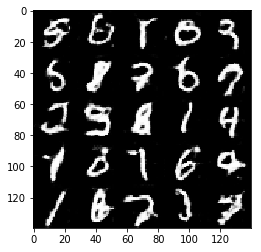

Epoch 4/5... Discriminator Loss: 0.5554... Generator Loss: 1.5400...
Epoch 4/5... Discriminator Loss: 0.5793... Generator Loss: 1.5112...
Epoch 4/5... Discriminator Loss: 0.5854... Generator Loss: 1.5017...
Epoch 4/5... Discriminator Loss: 1.0009... Generator Loss: 0.6201...
Epoch 4/5... Discriminator Loss: 0.6365... Generator Loss: 1.3058...


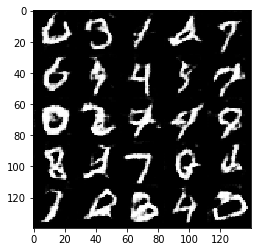

Epoch 4/5... Discriminator Loss: 0.5939... Generator Loss: 1.3027...
Epoch 4/5... Discriminator Loss: 0.6225... Generator Loss: 1.0645...
Epoch 4/5... Discriminator Loss: 0.7568... Generator Loss: 0.8989...
Epoch 4/5... Discriminator Loss: 0.4962... Generator Loss: 1.6330...
Epoch 4/5... Discriminator Loss: 0.6186... Generator Loss: 1.1711...


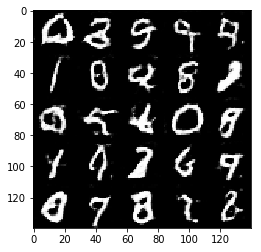

Epoch 4/5... Discriminator Loss: 0.5791... Generator Loss: 1.2890...
Epoch 4/5... Discriminator Loss: 0.7996... Generator Loss: 0.8469...
Epoch 4/5... Discriminator Loss: 0.6381... Generator Loss: 2.1126...
Epoch 5/5... Discriminator Loss: 0.6684... Generator Loss: 1.1356...
Epoch 5/5... Discriminator Loss: 0.5776... Generator Loss: 1.7588...


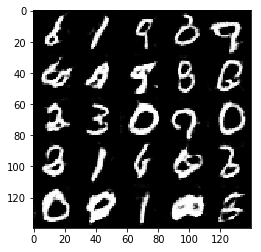

Epoch 5/5... Discriminator Loss: 0.3377... Generator Loss: 1.9632...
Epoch 5/5... Discriminator Loss: 0.6722... Generator Loss: 0.9858...
Epoch 5/5... Discriminator Loss: 0.4947... Generator Loss: 1.7661...
Epoch 5/5... Discriminator Loss: 0.7069... Generator Loss: 0.9400...
Epoch 5/5... Discriminator Loss: 0.6770... Generator Loss: 0.9647...


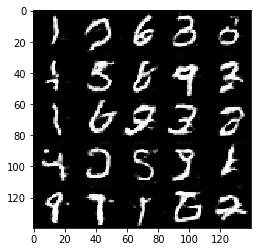

Epoch 5/5... Discriminator Loss: 0.5050... Generator Loss: 1.4671...
Epoch 5/5... Discriminator Loss: 1.1504... Generator Loss: 0.5172...
Epoch 5/5... Discriminator Loss: 0.9587... Generator Loss: 0.6357...
Epoch 5/5... Discriminator Loss: 0.8319... Generator Loss: 0.7577...
Epoch 5/5... Discriminator Loss: 0.5046... Generator Loss: 1.3922...


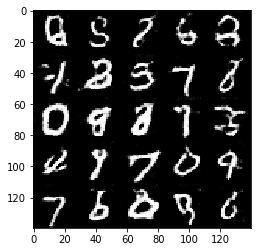

Epoch 5/5... Discriminator Loss: 0.6017... Generator Loss: 1.1842...
Epoch 5/5... Discriminator Loss: 0.7123... Generator Loss: 1.0030...
Epoch 5/5... Discriminator Loss: 0.6040... Generator Loss: 1.2425...
Epoch 5/5... Discriminator Loss: 0.5105... Generator Loss: 1.4483...
Epoch 5/5... Discriminator Loss: 0.4545... Generator Loss: 1.6231...


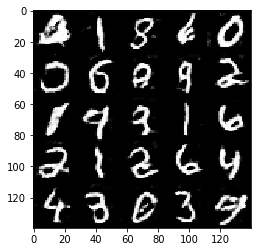

Epoch 5/5... Discriminator Loss: 1.5363... Generator Loss: 0.4517...
Epoch 5/5... Discriminator Loss: 0.7495... Generator Loss: 1.1170...
Epoch 5/5... Discriminator Loss: 0.7482... Generator Loss: 0.9275...
Epoch 5/5... Discriminator Loss: 0.6523... Generator Loss: 1.0970...
Epoch 5/5... Discriminator Loss: 0.5310... Generator Loss: 1.4643...


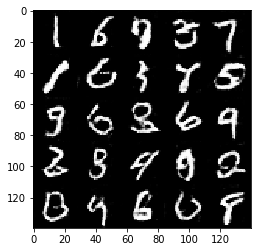

Epoch 5/5... Discriminator Loss: 0.6334... Generator Loss: 1.2162...
Epoch 5/5... Discriminator Loss: 0.5495... Generator Loss: 1.3992...
final Discriminator Loss: 0.5495... Generator Loss: 1.3992


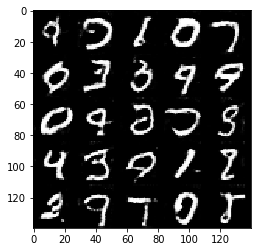

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/2... Discriminator Loss: 3.0794... Generator Loss: 0.1652...
Epoch 1/2... Discriminator Loss: 0.3719... Generator Loss: 9.2004...
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.6838...
Epoch 1/2... Discriminator Loss: 0.4501... Generator Loss: 2.0255...
Epoch 1/2... Discriminator Loss: 1.6692... Generator Loss: 0.3228...


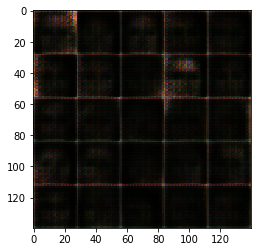

Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 0.9579...
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.9497...
Epoch 1/2... Discriminator Loss: 0.7682... Generator Loss: 1.5954...
Epoch 1/2... Discriminator Loss: 0.9384... Generator Loss: 0.8258...
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 3.9114...


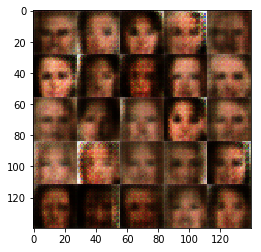

Epoch 1/2... Discriminator Loss: 1.9716... Generator Loss: 5.7013...
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.1793...
Epoch 1/2... Discriminator Loss: 0.6674... Generator Loss: 0.9883...
Epoch 1/2... Discriminator Loss: 1.6502... Generator Loss: 0.2881...
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 4.2277...


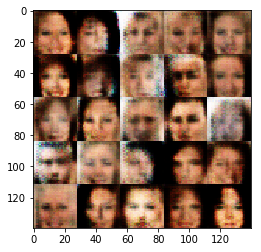

Epoch 1/2... Discriminator Loss: 0.5553... Generator Loss: 1.3625...
Epoch 1/2... Discriminator Loss: 0.2115... Generator Loss: 2.6093...
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 1.4808...
Epoch 1/2... Discriminator Loss: 0.2453... Generator Loss: 2.4001...
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 0.5741...


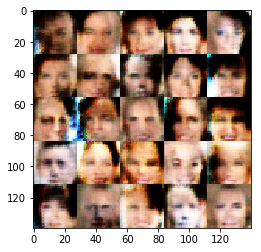

Epoch 1/2... Discriminator Loss: 0.2791... Generator Loss: 1.9034...
Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 1.6342...
Epoch 1/2... Discriminator Loss: 4.5934... Generator Loss: 4.9494...
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 0.9901...
Epoch 1/2... Discriminator Loss: 0.2996... Generator Loss: 3.4848...


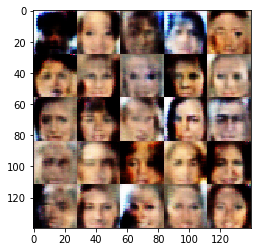

Epoch 1/2... Discriminator Loss: 0.4056... Generator Loss: 4.9203...
Epoch 1/2... Discriminator Loss: 0.7703... Generator Loss: 4.9986...
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 0.8862...
Epoch 1/2... Discriminator Loss: 1.8397... Generator Loss: 1.0824...
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 2.6954...


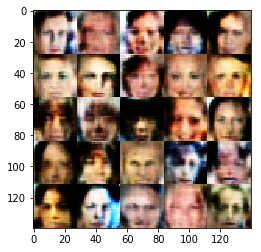

Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.8730...
Epoch 1/2... Discriminator Loss: 0.2031... Generator Loss: 2.6345...
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 0.8473...
Epoch 1/2... Discriminator Loss: 0.2838... Generator Loss: 2.8773...
Epoch 1/2... Discriminator Loss: 2.3343... Generator Loss: 0.1595...


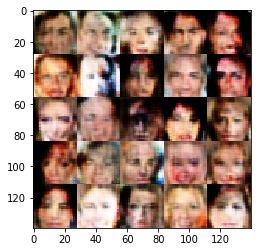

Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 2.6555...
Epoch 1/2... Discriminator Loss: 0.2229... Generator Loss: 2.6540...
Epoch 1/2... Discriminator Loss: 1.4386... Generator Loss: 0.4521...
Epoch 1/2... Discriminator Loss: 0.7391... Generator Loss: 1.4370...
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 4.2999...


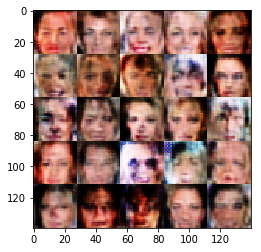

Epoch 1/2... Discriminator Loss: 0.3638... Generator Loss: 1.8331...
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.4368...
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 2.2962...
Epoch 1/2... Discriminator Loss: 0.7108... Generator Loss: 2.3260...
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 2.1825...


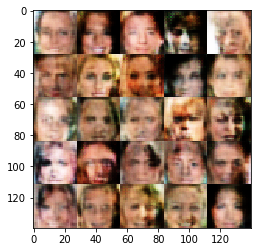

Epoch 1/2... Discriminator Loss: 0.2842... Generator Loss: 2.4151...
Epoch 1/2... Discriminator Loss: 0.6000... Generator Loss: 1.2394...
Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 1.4469...
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.4998...
Epoch 1/2... Discriminator Loss: 0.8743... Generator Loss: 0.7576...


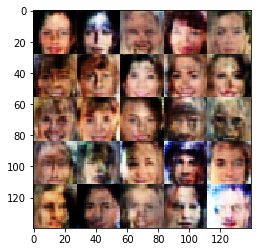

Epoch 1/2... Discriminator Loss: 0.9745... Generator Loss: 1.6324...
Epoch 1/2... Discriminator Loss: 2.0113... Generator Loss: 2.9437...
Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 1.9790...
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.3462...
Epoch 1/2... Discriminator Loss: 0.4580... Generator Loss: 1.7830...


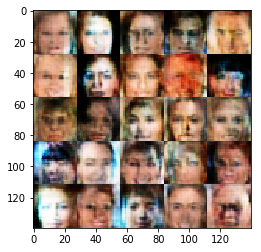

Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.6187...
Epoch 1/2... Discriminator Loss: 0.7985... Generator Loss: 1.5547...
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 2.7067...
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.8286...
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 0.9114...


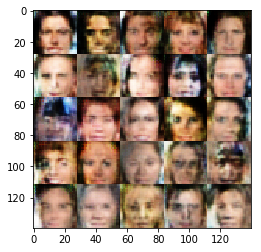

Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.6285...
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.3015...
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.4934...
Epoch 1/2... Discriminator Loss: 0.3615... Generator Loss: 2.0949...
Epoch 1/2... Discriminator Loss: 0.1472... Generator Loss: 4.1845...


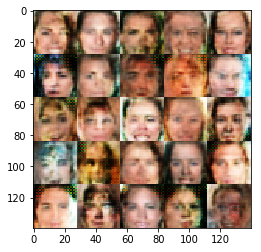

Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.6573...
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 2.2572...
Epoch 1/2... Discriminator Loss: 1.7120... Generator Loss: 0.3094...
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 2.1550...
Epoch 1/2... Discriminator Loss: 0.4957... Generator Loss: 2.0733...


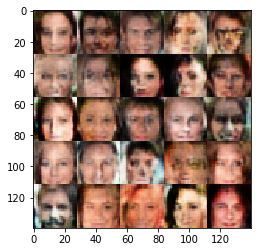

Epoch 1/2... Discriminator Loss: 0.1874... Generator Loss: 2.5173...
Epoch 1/2... Discriminator Loss: 0.3310... Generator Loss: 2.5621...
Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 0.8792...
Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 2.4974...
Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 0.7653...


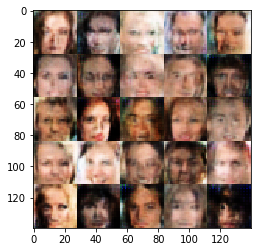

Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 0.6220...
Epoch 1/2... Discriminator Loss: 0.5044... Generator Loss: 1.5907...
Epoch 1/2... Discriminator Loss: 0.6396... Generator Loss: 2.4411...
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 0.5733...
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.5191...


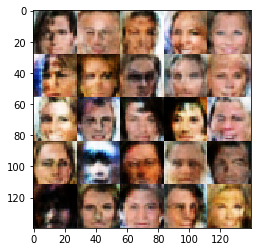

Epoch 2/2... Discriminator Loss: 2.0489... Generator Loss: 3.2948...
Epoch 2/2... Discriminator Loss: 0.5145... Generator Loss: 1.5086...
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 0.9644...
Epoch 2/2... Discriminator Loss: 0.5340... Generator Loss: 3.2736...
Epoch 2/2... Discriminator Loss: 1.7915... Generator Loss: 0.2785...


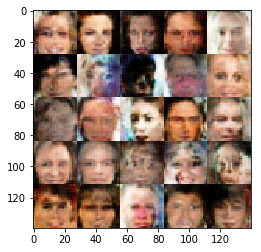

Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 1.3887...
Epoch 2/2... Discriminator Loss: 1.6179... Generator Loss: 3.8992...
Epoch 2/2... Discriminator Loss: 0.5102... Generator Loss: 1.5198...
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 0.8602...
Epoch 2/2... Discriminator Loss: 0.9095... Generator Loss: 1.3999...


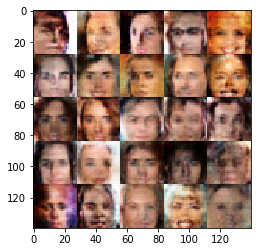

Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 0.9305...
Epoch 2/2... Discriminator Loss: 2.1930... Generator Loss: 3.2700...
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 1.9820...
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 1.3024...
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 0.9321...


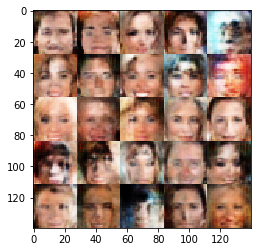

Epoch 2/2... Discriminator Loss: 1.1192... Generator Loss: 0.6122...
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 3.0895...
Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 1.0192...
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 2.7499...
Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 1.2753...


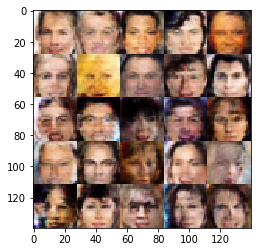

Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 2.6207...
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.1320...
Epoch 2/2... Discriminator Loss: 0.1793... Generator Loss: 2.5918...
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.5498...
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.6846...


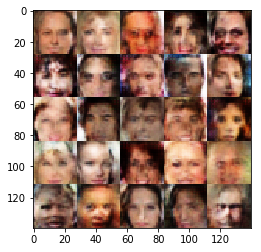

Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 0.8033...
Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 1.1030...
Epoch 2/2... Discriminator Loss: 0.5059... Generator Loss: 1.7684...
Epoch 2/2... Discriminator Loss: 0.4620... Generator Loss: 1.5890...
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.6501...


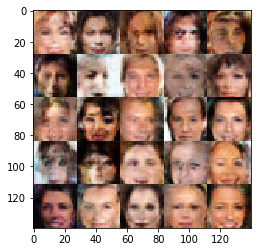

Epoch 2/2... Discriminator Loss: 0.3405... Generator Loss: 2.4701...
Epoch 2/2... Discriminator Loss: 0.6657... Generator Loss: 2.6535...
Epoch 2/2... Discriminator Loss: 0.6130... Generator Loss: 1.1388...
Epoch 2/2... Discriminator Loss: 0.3145... Generator Loss: 2.0687...
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 0.8770...


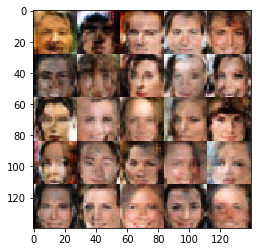

Epoch 2/2... Discriminator Loss: 0.2763... Generator Loss: 2.2932...
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 1.0959...
Epoch 2/2... Discriminator Loss: 1.1918... Generator Loss: 3.2474...
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 1.2494...
Epoch 2/2... Discriminator Loss: 0.2648... Generator Loss: 2.4705...


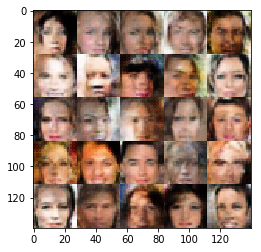

Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 1.6435...
Epoch 2/2... Discriminator Loss: 1.2757... Generator Loss: 3.0997...
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 1.7142...
Epoch 2/2... Discriminator Loss: 1.2749... Generator Loss: 0.4845...
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 1.5214...


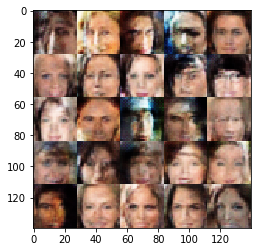

Epoch 2/2... Discriminator Loss: 0.6377... Generator Loss: 1.2235...
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 1.1482...
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 0.6926...
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.5878...
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.7079...


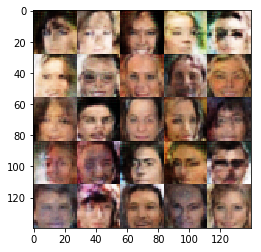

Epoch 2/2... Discriminator Loss: 0.5615... Generator Loss: 1.7336...
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 0.8441...
Epoch 2/2... Discriminator Loss: 0.5137... Generator Loss: 1.3208...
Epoch 2/2... Discriminator Loss: 0.4919... Generator Loss: 2.6268...
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.6787...


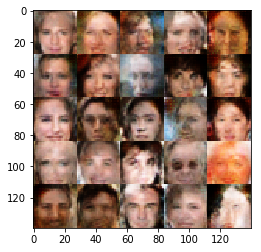

Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 2.2780...
Epoch 2/2... Discriminator Loss: 0.5592... Generator Loss: 3.0881...
Epoch 2/2... Discriminator Loss: 0.6786... Generator Loss: 3.0337...
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.0040...
Epoch 2/2... Discriminator Loss: 0.5020... Generator Loss: 1.3701...


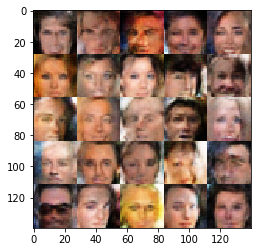

Epoch 2/2... Discriminator Loss: 0.4135... Generator Loss: 1.8219...
Epoch 2/2... Discriminator Loss: 0.4875... Generator Loss: 1.8844...
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.7372...
Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 2.1457...
Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.4437...


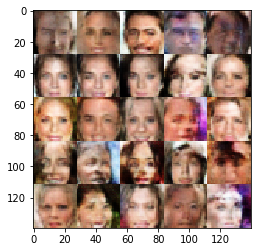

Epoch 2/2... Discriminator Loss: 0.5257... Generator Loss: 1.3654...
Epoch 2/2... Discriminator Loss: 0.5046... Generator Loss: 2.2078...
Epoch 2/2... Discriminator Loss: 0.3930... Generator Loss: 1.8075...
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.4314...
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 1.9396...


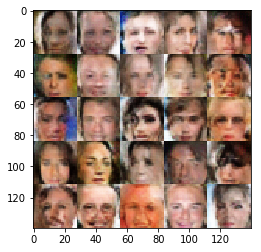

Epoch 2/2... Discriminator Loss: 0.6769... Generator Loss: 0.9609...
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.1856...
Epoch 2/2... Discriminator Loss: 2.0589... Generator Loss: 4.0157...
Epoch 2/2... Discriminator Loss: 0.4631... Generator Loss: 1.8201...
Epoch 2/2... Discriminator Loss: 0.7581... Generator Loss: 1.0049...


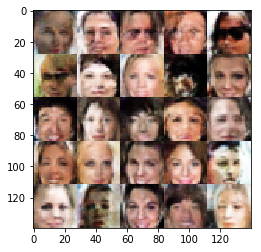

Epoch 2/2... Discriminator Loss: 0.4440... Generator Loss: 1.4841...
Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 2.2868...
Epoch 2/2... Discriminator Loss: 1.5241... Generator Loss: 0.3655...
final Discriminator Loss: 1.5241... Generator Loss: 0.3655


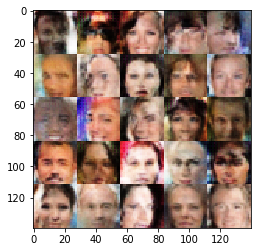

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。